### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git clone --recursive https://github.com/omron-sinicx/neural-astar

In [ ]:
%cd neural-astar
!pip install -U pip setuptools
!pip install .

## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [1]:
import sys
sys.path.append('/media/storage/data/moonlab/camel+/neural-astar/src/')
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
#from neural_astar.utils.training import load_from_ptl_checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
#neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/mazes_032_moore_c8/lightning_logs/"))

vanilla_astar = VanillaAstar().to(device)

Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

In [2]:
import numpy as np
import sys
import torch.utils.data as data
np.set_printoptions(threshold=sys.maxsize)
#ar = np.load("/content/neural-astar/planning-datasets/data/mpd/mazes_032_moore_c8.npz")
#print(ar['arr_9'][0].shape)
cmap = np.zeros((4,1,40,28)).astype(np.float32)
smap = np.zeros((4,1,40,28)).astype(np.float32)
for i in smap:
    i[0][21,0] = 1

gmap = np.zeros((4,1,40,28)).astype(np.float32)
for i in gmap:
    i[0][9,25] = 1

costmap = np.abs(np.load('/media/storage/data/moonlab/camel+/141.npy',allow_pickle = True).reshape(1,40,28).astype(np.float32) -1)
cmap[0] = costmap
cmap[1] = costmap
cmap[2] = costmap
cmap[3] = costmap
print(cmap.shape)
map = torch.from_numpy(cmap)
start = torch.from_numpy(smap)
goal = torch.from_numpy(gmap)

(4, 1, 40, 28)


Number of Test Samples: 100
	Size: 32x32


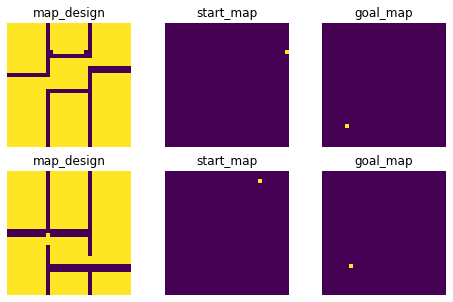

In [5]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader

dataloader = create_dataloader("/media/storage/data/moonlab/camel+/neural-astar/planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

(tensor([0, 0, 0], device='cuda:0'), tensor([ 9, 10, 11], device='cuda:0'), tensor([25, 23, 18], device='cuda:0'))


(-0.5, 121.5, 43.5, -0.5)

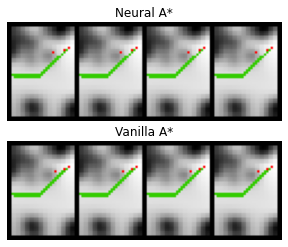

In [12]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(map.to(device), start.to(device), goal.to(device))
vanilla_astar.eval()
print(torch.where(na_outputs.paths[3]>0.5))
va_outputs = vanilla_astar(map.to(device), start.to(device), goal.to(device))
fig, axes = plt.subplots(2, 1, figsize=[12, 4])
axes[0].imshow(visualize_results(map, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")